In [1]:
from dotenv import load_dotenv
import os

load_dotenv(override=True)  # Loads variables from .env into environment

calendar_file = os.getenv("CALENDAR_FILE")
calendarific_api_key = os.getenv("CALENDARIFIC_API_KEY")
country_code = os.getenv("COUNTRY_CODE")
latitude = float(os.getenv("LATITUDE"))
longitude = float(os.getenv("LONGITUDE"))
timezone = os.getenv("TIMEZONE")
weather_file = os.getenv("WEATHER_FILE")


In [2]:

import requests
import json
import os
import pandas as pd


def load_file_cal():
    if os.path.exists(calendar_file):
        with open(calendar_file, "r") as fc:
            return fc.readlines()
    return None


def get_holidays(year, country_code, api_key,lines_fc):
    #print(lines_fc)

    try:
        for line in lines_fc:
            try:
                data = json.loads(line)

                if data["response"]["holidays"][0]["date"]["datetime"]["year"] == year:
                    # Found cached year
                    holidays = [item["date"]["iso"] for item in data["response"]["holidays"]]
                    return pd.to_datetime(holidays),lines_fc
            except json.JSONDecodeError as e:
                print("JSON decode failed:", e)
                print("Offending line:", repr(line))
                continue  # Skip malformed lines    
    except Exception as e:
            print(f"Error retrieving holidays data from file")
    try:
            url = (
            f"https://calendarific.com/api/v2/holidays?"
            f"api_key={api_key}&country={country_code}&year={year}&type=national"
            )
            response = requests.get(url)
            if response.status_code == 200:
                data = response.json()

                # Save response
                with open(calendar_file, "a") as f:
                    f.write(json.dumps(data) + "\n")

                lines_fc = load_file_cal()

                holidays = [item["date"]["iso"] for item in data["response"]["holidays"]]
                return pd.to_datetime(holidays),lines_fc
            else:
                print(f"Calendarific API error for year {year}: Status {response.status_code} - {response.text}")
                return pd.to_datetime([])

    except Exception as e:
            print(f"Error retrieving holidays for {year}: {e}")
            return pd.to_datetime([])
        




In [4]:
import requests
from datetime import datetime
import json
import os





def load_file_weath():
    if os.path.exists(weather_file):
        with open(weather_file, "r") as fw:      
            return fw.readlines()
    return None



def weatherdata(date_str,lines_fw):
    try:
        for line in lines_fw:
            try:
                data = json.loads(line)
                if data["daily"]["time"][0] == date_str:
                    # If date already exists, use it
                    #print(f"Using cached data for {date_str}")
                    day_data = data["daily"]
                    return {
                        "temperature": (day_data["temperature_2m_max"][0] + day_data["temperature_2m_min"][0]) / 2,
                        "weather_main": "Rain" if day_data["precipitation_sum"][0] > 0 else "Clear"
                    },lines_fw
            except Exception as e:
                continue  # Skip bad lines
    except Exception as e:
            print(f"Error retrieving weather data from file")
    # If not found in file, call API
    try:
        url = (
            f"https://archive-api.open-meteo.com/v1/archive?"
            f"latitude={latitude}&longitude={longitude}"
            f"&start_date={date_str}&end_date={date_str}"
            f"&daily=temperature_2m_max,temperature_2m_min,precipitation_sum"
            f"&timezone={timezone}"
        )

        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()

            # Append to file
            with open(weather_file, "a") as f:
                f.write(json.dumps(data) + "\n")

            lines_fw = load_file_weath()

            day_data = data["daily"]
            return {
                "temperature": (day_data["temperature_2m_max"][0] + day_data["temperature_2m_min"][0]) / 2,
                "weather_main": "Rain" if day_data["precipitation_sum"][0] > 0 else "Clear",   
            },lines_fw

        else:
            print(f"Open-Meteo API error on {date_str}: Status {response.status_code}")
            return None

    except Exception as e:
        print(f"Error on {date_str}: {e}")
        return None




Food Name
Strawberry Sunrise                      5045
Creole Shrimp and Grits                 4381
Southern Fried Catfish Po' Boy          4297
Sweet Tea-Brined Pork Chops             4149
Crispy Karma                            4055
                                        ... 
Cucumber Basil Smash                      61
The Dynamic Duo Surf and Turf Burger      56
The Pesto Basil Chicken Burger            34
Spicey Mettra                             17
Citrus Splash                             15
Name: count, Length: 122, dtype: int64
HolidaY data Loaded
Weather data Loaded
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1550 entries, 0 to 1549
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1550 non-null   datetime64[ns]
 1   Quantity_Sold      1550 non-null   int64         
 2   day_of_week        1550 non-null   int32         
 3   is_weekend         1550 non-n

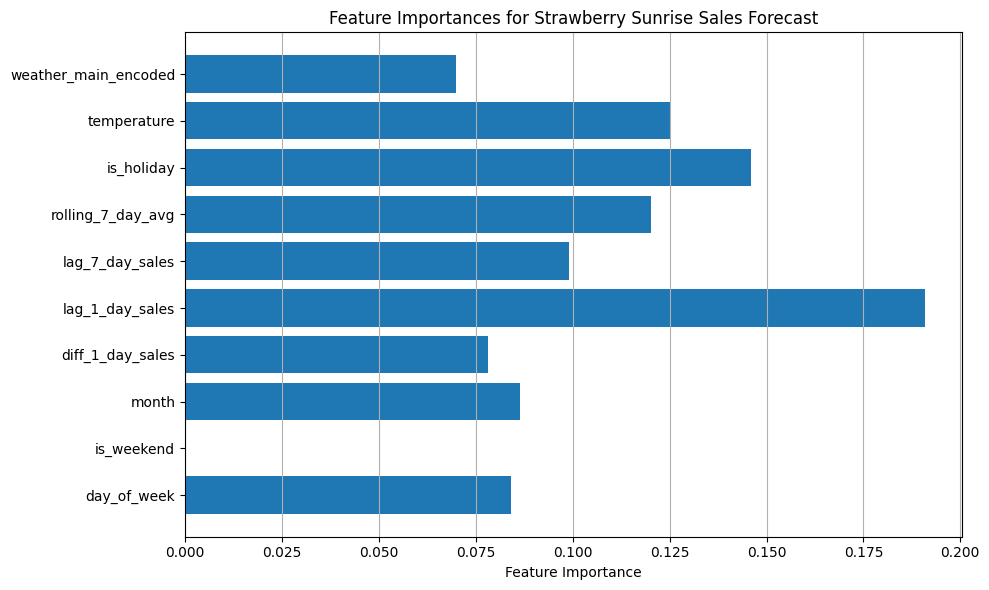

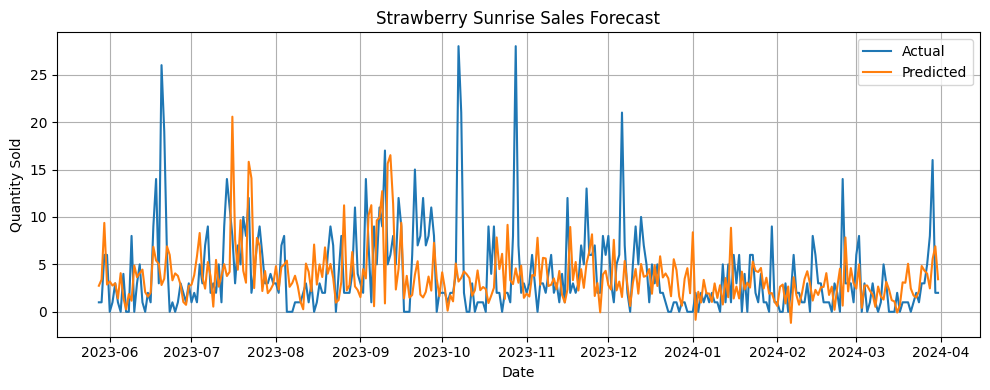

In [11]:

import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

sales_df = pd.read_excel("Sales Dataset OG.xlsx")

print(sales_df["Food Name"].value_counts())

dish_name = "Crispy Karma"
df = sales_df[sales_df["Food Name"] == dish_name][["System Date", "Quantity"]].copy()
df.columns = ["Date", "Quantity_Sold"]
df["Date"] = pd.to_datetime(df["Date"])

# if in case
df = df.set_index("Date").resample("D").sum().fillna(0).reset_index()

# Feature Engineering
df["day_of_week"] = df["Date"].dt.dayofweek
df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
df["month"] = df["Date"].dt.month
df["diff_1_day_sales"] = df["Quantity_Sold"].shift(1).diff(1).fillna(0)
df["diff_7_day_sales"] = df["Quantity_Sold"].diff(7).fillna(0)  
df["lag_1_day_sales"] = df["Quantity_Sold"].shift(1).fillna(0)  
df["lag_7_day_sales"] = df["Quantity_Sold"].shift(7).fillna(0)  
df["rolling_7_day_avg"] = df["Quantity_Sold"].shift(1).rolling(7).mean()


lines_fc = load_file_cal()
lines_fw = load_file_weath()

# Add is_holiday flag based on API response
years = df["Date"].dt.year.unique()
all_holiday_dates = pd.DatetimeIndex([])
for yr in years:
    holidays,lines_fc = get_holidays(yr, country_code, calendarific_api_key,lines_fc)
    all_holiday_dates = all_holiday_dates.union(holidays)

df["is_holiday"] = df["Date"].isin(all_holiday_dates).astype(int)

print("HolidaY data Loaded")   

# Convert your date column to string format needed by the API
df["weather_date"] = df["Date"].dt.strftime("%Y-%m-%d")

# Create placeholder columns
df["temperature"] = 0.0
df["weather_main"] = None

# Loop over unique dates to fetch weather data
for i, row in df.iterrows():
    date_str = row["weather_date"]
    weather,lines_fw = weatherdata(date_str,lines_fw)
    if weather:
       df.at[i, "temperature"] = weather["temperature"]
       df.at[i, "weather_main"] = weather["weather_main"]
    #time.sleep(1)

print("Weather data Loaded")   

print(df.info())
#print(df['temperature'].head())



# Encode weather
df = df.dropna()
le = LabelEncoder()
df["weather_main_encoded"] = le.fit_transform(df["weather_main"])

# Define X and y
features = ["day_of_week", "is_weekend", "month",
            "diff_1_day_sales",
            "lag_1_day_sales","lag_7_day_sales",
            "rolling_7_day_avg",
            "is_holiday", "temperature", "weather_main_encoded"]
target = "Quantity_Sold"

split = int(len(df) * 0.8)
X_train, y_train = df[features][:split], df[target][:split]
X_test, y_test = df[features][split:], df[target][split:]

# Train XGBoost model
model = XGBRegressor(objective="reg:squarederror", random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate
#rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n📊 Model Performance:")
#print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")


# Plot feature importances
plt.figure(figsize=(10, 6)) 
plt.barh(features, model.feature_importances_)
plt.xlabel("Feature Importance")
plt.title("Feature Importances for Strawberry Sunrise Sales Forecast")
plt.grid(axis='x')
plt.tight_layout()
plt.show()



# Plot results
plt.figure(figsize=(10, 4))
plt.plot(df["Date"][split:], y_test.values, label="Actual")
plt.plot(df["Date"][split:], y_pred, label="Predicted")
plt.title("Strawberry Sunrise Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

